<a href="https://colab.research.google.com/github/ferrazzijk/Instacart-ALS-Recommendation-System/blob/main/Instacart_Recs_Order.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Instacart Recommendation System**

The task at hand for this project was to build a model that adds value by solving a problem. 

In my case, I set out to work on something I hadn’t done before, as a way to work outside my comfort or knowledge zone. When the description of the final capstone mentioned some popular platforms recommendation systems, I thought that would be the perfect opportunity to flex my everything is figureoutable muscle. I found data Instacart released for orders from 2017 and knew this was the perfect opportunity to add value during a time when more people are turning to online grocery shopping and delivery.  

Instacart, if you’re unfamiliar, is a platform, available through an app or website, that allows customers to order groceries, for pick up or delivery, from participating retailers with the shopping being done by a personal shopper. 

Analyzed data included Data for
*   62,000 Orders
*   41,000 Customers
*   134 Aisles
*   31,728 Products

The data comes from Kaggle and can be found [here](https://www.kaggle.com/c/instacart-market-basket-analysis/data). 


# **Set Environment**

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 7.6MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670908 sha256=6c6fb92a4f78e3c5d79de9013e32b77e0b80a5e7841796688d22b9f620f4ab53
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 36kB/s 
     |████████████████████████████████| 204kB 54.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=00d775ebd70346207e7600909125d21085e96d9210508bb855ae6ea4b39204c7
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
#imports
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import  CrossValidator, ParamGridBuilder
from pyspark import SparkContext
from pyspark.sql import SQLContext

from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from statsmodels.tools.eval_measures import rmse

from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#load data

aisles_url ='https://www.dropbox.com/s/rtbqufy50bgypi9/aisles.csv?dl=1'
aisles_df = pd.read_csv(aisles_url)

departments_url = 'https://www.dropbox.com/s/hpv6yn04rsthyrv/departments.csv?dl=1'
dept_df = pd.read_csv(departments_url)

products_url = 'https://www.dropbox.com/s/6dwc75clzye3d8z/products.csv?dl=1'
products_df = pd.read_csv(products_url)

orders_url = 'https://www.dropbox.com/s/wiqx62x4w0ekuny/orders.csv?dl=1'
orders_df = pd.read_csv(orders_url)

prior_orders_url ='https://www.dropbox.com/s/6q3wxgxg3zr42rn/prior%20orders.csv?dl=1'
prior_orders_df = pd.read_csv(prior_orders_url)

train_orders_url ='https://www.dropbox.com/s/emlm2b5tqdv7jxo/training%20orders.csv?dl=1'
train_orders_df = pd.read_csv(train_orders_url)

# **Dataframe Explanations**



*   **Aisles:** Contains different aisles
*   **Departments:** Contains different departments
*   **Products:** Descriptions of the Prodcuts
*   **Orders:** Tells which Orders are in the Training, Test, & Prior Sets
*   **Prior Orders:** Prior Orders of Users
*   **Test Orders:** Orders in Test Set
*   **Train Orders:** Orders in Training Set





# **Exploratory Data Analysis & Cleaning**

## **Dataframe Exploration**

In [ ]:
#view aisles_df head & shape for initial inspection

print('Aisles Dataframe has {} rows and {} columns.'.format(aisles_df.shape[0], aisles_df.shape[1]))
aisles_df.head()

Aisles Dataframe has 134 rows and 2 columns.


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
#view dept_df head & shape for initial inspection

print('Departments Dataframe has {} rows and {} columns.'.format(dept_df.shape[0], dept_df.shape[1]))
dept_df.head()

Departments Dataframe has 21 rows and 2 columns.


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
#view products_df head & shape for initial inspection

print('Products Dataframe has {} rows and {} columns.'.format(products_df.shape[0], products_df.shape[1]))
products_df.head()

Products Dataframe has 49688 rows and 4 columns.


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
#view orders_df head & shape for initial inspection

print('Orders Dataframe has {} rows and {} columns.'.format(orders_df.shape[0], orders_df.shape[1]))
orders_df.head()

Orders Dataframe has 1048575 rows and 7 columns.


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
#view prior_orders_df head & shape for initial inspection

print('Prior Orders Dataframe has {} rows and {} columns.'.format(prior_orders_df.shape[0], prior_orders_df.shape[1]))
prior_orders_df.head()

Prior Orders Dataframe has 1048575 rows and 4 columns.


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
#view train_orders_df head & shape for initial inspection

print('Training Orders Dataframe has {} rows and {} columns.'.format(train_orders_df.shape[0], train_orders_df.shape[1]))
train_orders_df.head()

Training Orders Dataframe has 1048575 rows and 4 columns.


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## **Merging Data**

It will be helpful to combine prior & training orders with aisles, departments, and products to further investiage data. 

In [ ]:
#concatenate prior & training dfs
order_details = pd.concat([prior_orders_df, train_orders_df], axis=0)

#merge in 'product_id', 'aisle_id', & 'department_id' from products_df
order_details = order_details.merge(products_df[['product_id', 'aisle_id', 'department_id']],
                how='inner', on='product_id')

#merge in aisles
order_details = order_details.merge(aisles_df, on = 'aisle_id')

#merge in departments
order_details = order_details.merge(dept_df, on='department_id')

#merge in orders
order_details = order_details.merge(orders_df[['order_id', 'user_id']], on='order_id')

#merge in products
order_details = order_details.merge(products_df[['product_id', 'product_name']], on= 'product_id')

#view 
order_details

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id,product_name
0,120,33120,13,0,86,16,eggs,dairy eggs,23750,Organic Egg Whites
1,327,33120,5,1,86,16,eggs,dairy eggs,58707,Organic Egg Whites
2,623,33120,1,1,86,16,eggs,dairy eggs,37804,Organic Egg Whites
3,726,33120,3,1,86,16,eggs,dairy eggs,57362,Organic Egg Whites
4,1097,33120,14,1,86,16,eggs,dairy eggs,30502,Organic Egg Whites
...,...,...,...,...,...,...,...,...,...,...
638587,31925,24968,2,1,134,5,specialty wines champagnes,alcohol,47329,Sonoma Brut Sparkling Wine
638588,34570,49562,1,1,134,5,specialty wines champagnes,alcohol,37901,Blanc De Noirs Sparkling Wine
638589,2036125,22396,1,1,6,2,other,other,46854,Digital Pregnancy Test
638590,1611547,34152,2,0,6,2,other,other,9234,Water Based Personal Lubricant


In [ ]:
#rename add_to_cart_order 
order_details.rename(columns={'add_to_cart_order':'qty_purchased'}, inplace=True)

#reorder columns & ignore reordered
order_details = order_details[['user_id','order_id','product_id', 'product_name',
'qty_purchased', 'aisle_id', 'aisle', 'department_id', 'department']]

#view
order_details

,user_id,order_id,product_id,product_name,qty_purchased,aisle_id,aisle,department_id,department
0,23750,120,33120,Organic Egg Whites,13,86,eggs,16,dairy eggs
1,58707,327,33120,Organic Egg Whites,5,86,eggs,16,dairy eggs
2,37804,623,33120,Organic Egg Whites,1,86,eggs,16,dairy eggs
3,57362,726,33120,Organic Egg Whites,3,86,eggs,16,dairy eggs
4,30502,1097,33120,Organic Egg Whites,14,86,eggs,16,dairy eggs
...,...,...,...,...,...,...,...,...,...
638587,47329,31925,24968,Sonoma Brut Sparkling Wine,2,134,specialty wines champagnes,5,alcohol
638588,37901,34570,49562,Blanc De Noirs Sparkling Wine,1,134,specialty wines champagnes,5,alcohol
638589,46854,2036125,22396,Digital Pregnancy Test,1,6,other,2,other
638590,9234,1611547,34152,Water Based Personal Lubricant,2,6,other,2,other


In [ ]:
#replace blank space in product_name with an underscore so later visualizations
#of popular products are more accurate
order_details.product_name = order_details.product_name.str.replace(' ','_')
order_details

,user_id,order_id,product_id,product_name,qty_purchased,aisle_id,aisle,department_id,department
0,23750,120,33120,Organic_Egg_Whites,13,86,eggs,16,dairy eggs
1,58707,327,33120,Organic_Egg_Whites,5,86,eggs,16,dairy eggs
2,37804,623,33120,Organic_Egg_Whites,1,86,eggs,16,dairy eggs
3,57362,726,33120,Organic_Egg_Whites,3,86,eggs,16,dairy eggs
4,30502,1097,33120,Organic_Egg_Whites,14,86,eggs,16,dairy eggs
...,...,...,...,...,...,...,...,...,...
638587,47329,31925,24968,Sonoma_Brut_Sparkling_Wine,2,134,specialty wines champagnes,5,alcohol
638588,37901,34570,49562,Blanc_De_Noirs_Sparkling_Wine,1,134,specialty wines champagnes,5,alcohol
638589,46854,2036125,22396,Digital_Pregnancy_Test,1,6,other,2,other
638590,9234,1611547,34152,Water_Based_Personal_Lubricant,2,6,other,2,other


In [ ]:
#View data types
order_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638592 entries, 0 to 638591
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        638592 non-null  int64 
 1   order_id       638592 non-null  int64 
 2   product_id     638592 non-null  int64 
 3   product_name   638592 non-null  object
 4   qty_purchased  638592 non-null  int64 
 5   aisle_id       638592 non-null  int64 
 6   aisle          638592 non-null  object
 7   department_id  638592 non-null  int64 
 8   department     638592 non-null  object
dtypes: int64(6), object(3)
memory usage: 48.7+ MB


## **Missing Data**

I don't anticipate missing data due to source of data, but it doesn't hurt to check. 

In [ ]:
#missing data check
total_missing = order_details.isnull().sum().sort_values(ascending=False)
percent_missing = (order_details.isnull().sum()/order_details.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
department,0,0.0
department_id,0,0.0
aisle,0,0.0
aisle_id,0,0.0
qty_purchased,0,0.0
product_name,0,0.0
product_id,0,0.0
order_id,0,0.0
user_id,0,0.0


## **Creating New Dataframes that will be used later on.**

### **User Product History**

Used in Personalized Recommender System

In [ ]:
#create a df of user product history
user_product_hist = order_details[['product_id','product_name', 'user_id','qty_purchased']].groupby(['product_id','product_name','user_id']).sum().reset_index()
user_product_hist = pd.DataFrame(data=user_product_hist)

In [ ]:
user_product_hist

,product_id,product_name,user_id,qty_purchased
0,1,Chocolate_Sandwich_Cookies,751,4
1,1,Chocolate_Sandwich_Cookies,1540,7
2,1,Chocolate_Sandwich_Cookies,2221,5
3,1,Chocolate_Sandwich_Cookies,4122,1
4,1,Chocolate_Sandwich_Cookies,9694,3
...,...,...,...,...
583670,49683,Cucumber_Kirby,63073,13
583671,49683,Cucumber_Kirby,63087,8
583672,49686,Artisan_Baguette,45297,1
583673,49688,Fresh_Foaming_Cleanser,39679,4


### **Product History**

Used in Personalized Recommender System & Cosine Similarity

In [ ]:
#create a df of product history
product_hist = order_details[['product_id', 'product_name', 'qty_purchased']].groupby(['product_id', 'product_name']).sum().reset_index()
product_hist = pd.DataFrame(data=product_hist)
product_hist

,product_id,product_name,qty_purchased
0,1,Chocolate_Sandwich_Cookies,265
1,2,All-Seasons_Salt,82
2,3,Robust_Golden_Unsweetened_Oolong_Tea,6
3,4,Smart_Ones_Classic_Favorites_Mini_Rigatoni_Wit...,91
4,8,Cut_Russet_Potatoes_Steam_N'_Mash,73
...,...,...,...
31723,49681,Spaghetti_with_Meatballs_and_Sauce_Meal,33
31724,49682,California_Limeade,15
31725,49683,Cucumber_Kirby,11082
31726,49686,Artisan_Baguette,1


In [ ]:
#add a column to product_hist to represent the percent a product's qty_purchased
#is of all total quantities
product_hist['qty_purchased_percent'] = (product_hist['qty_purchased']/product_hist['qty_purchased'].sum())*100
product_hist

,product_id,product_name,qty_purchased,qty_purchased_percent
0,1,Chocolate_Sandwich_Cookies,265,0.004870
1,2,All-Seasons_Salt,82,0.001507
2,3,Robust_Golden_Unsweetened_Oolong_Tea,6,0.000110
3,4,Smart_Ones_Classic_Favorites_Mini_Rigatoni_Wit...,91,0.001672
4,8,Cut_Russet_Potatoes_Steam_N'_Mash,73,0.001342
...,...,...,...,...
31723,49681,Spaghetti_with_Meatballs_and_Sauce_Meal,33,0.000606
31724,49682,California_Limeade,15,0.000276
31725,49683,Cucumber_Kirby,11082,0.203665
31726,49686,Artisan_Baguette,1,0.000018


### **Product Details**

Used in Top Products Recommender

In [ ]:
#create a df of product_details
product_details = order_details[['order_id','product_id', 'product_name','aisle_id', 'aisle', 'department_id', 'department']]
product_details

,order_id,product_id,product_name,aisle_id,aisle,department_id,department
0,120,33120,Organic_Egg_Whites,86,eggs,16,dairy eggs
1,327,33120,Organic_Egg_Whites,86,eggs,16,dairy eggs
2,623,33120,Organic_Egg_Whites,86,eggs,16,dairy eggs
3,726,33120,Organic_Egg_Whites,86,eggs,16,dairy eggs
4,1097,33120,Organic_Egg_Whites,86,eggs,16,dairy eggs
...,...,...,...,...,...,...,...
638587,31925,24968,Sonoma_Brut_Sparkling_Wine,134,specialty wines champagnes,5,alcohol
638588,34570,49562,Blanc_De_Noirs_Sparkling_Wine,134,specialty wines champagnes,5,alcohol
638589,2036125,22396,Digital_Pregnancy_Test,6,other,2,other
638590,1611547,34152,Water_Based_Personal_Lubricant,6,other,2,other


In [ ]:
#group product details by product_id
product_details = product_details.groupby('product_id', as_index=False).agg(set)
product_details

,product_id,order_id,product_name,aisle_id,aisle,department_id,department
0,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks}
1,2,"{12209, 1550225, 1455635, 2481009, 105042, 59102}",{All-Seasons_Salt},{104},{spices seasonings},{13},{pantry}
2,3,"{36875, 2339119}",{Robust_Golden_Unsweetened_Oolong_Tea},{94},{tea},{7},{beverages}
3,4,"{13379, 63749, 2472936, 90473, 2179434, 934893...",{Smart_Ones_Classic_Favorites_Mini_Rigatoni_Wi...,{38},{frozen meals},{1},{frozen}
4,8,"{66768, 507098, 1896509, 1095600}",{Cut_Russet_Potatoes_Steam_N'_Mash},{116},{frozen produce},{1},{frozen}
...,...,...,...,...,...,...,...
31723,49681,"{344568, 768013, 711477}",{Spaghetti_with_Meatballs_and_Sauce_Meal},{38},{frozen meals},{1},{frozen}
31724,49682,"{2165322, 679895}",{California_Limeade},{98},{juice nectars},{7},{beverages}
31725,49683,"{278529, 57351, 73744, 8211, 106516, 65568, 41...",{Cucumber_Kirby},{83},{fresh vegetables},{4},{produce}
31726,49686,{2133651},{Artisan_Baguette},{112},{bread},{3},{bakery}


In [ ]:
#create a column that shows the amount of orders a product was purchased in
product_details['num_orders'] = product_details['order_id'].str.len()
product_details

,product_id,order_id,product_name,aisle_id,aisle,department_id,department,num_orders
0,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks},42
1,2,"{12209, 1550225, 1455635, 2481009, 105042, 59102}",{All-Seasons_Salt},{104},{spices seasonings},{13},{pantry},6
2,3,"{36875, 2339119}",{Robust_Golden_Unsweetened_Oolong_Tea},{94},{tea},{7},{beverages},2
3,4,"{13379, 63749, 2472936, 90473, 2179434, 934893...",{Smart_Ones_Classic_Favorites_Mini_Rigatoni_Wi...,{38},{frozen meals},{1},{frozen},11
4,8,"{66768, 507098, 1896509, 1095600}",{Cut_Russet_Potatoes_Steam_N'_Mash},{116},{frozen produce},{1},{frozen},4
...,...,...,...,...,...,...,...,...
31723,49681,"{344568, 768013, 711477}",{Spaghetti_with_Meatballs_and_Sauce_Meal},{38},{frozen meals},{1},{frozen},3
31724,49682,"{2165322, 679895}",{California_Limeade},{98},{juice nectars},{7},{beverages},2
31725,49683,"{278529, 57351, 73744, 8211, 106516, 65568, 41...",{Cucumber_Kirby},{83},{fresh vegetables},{4},{produce},1485
31726,49686,{2133651},{Artisan_Baguette},{112},{bread},{3},{bakery},1


In [ ]:
#merge in qty_purchased from product_hist df
product_details = product_details.merge(product_hist[['product_id', 'qty_purchased']], on='product_id', how='inner')
product_details

,product_id,order_id,product_name,aisle_id,aisle,department_id,department,num_orders,qty_purchased
0,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks},42,265
1,2,"{12209, 1550225, 1455635, 2481009, 105042, 59102}",{All-Seasons_Salt},{104},{spices seasonings},{13},{pantry},6,82
2,3,"{36875, 2339119}",{Robust_Golden_Unsweetened_Oolong_Tea},{94},{tea},{7},{beverages},2,6
3,4,"{13379, 63749, 2472936, 90473, 2179434, 934893...",{Smart_Ones_Classic_Favorites_Mini_Rigatoni_Wi...,{38},{frozen meals},{1},{frozen},11,91
4,8,"{66768, 507098, 1896509, 1095600}",{Cut_Russet_Potatoes_Steam_N'_Mash},{116},{frozen produce},{1},{frozen},4,73
...,...,...,...,...,...,...,...,...,...
31723,49681,"{344568, 768013, 711477}",{Spaghetti_with_Meatballs_and_Sauce_Meal},{38},{frozen meals},{1},{frozen},3,33
31724,49682,"{2165322, 679895}",{California_Limeade},{98},{juice nectars},{7},{beverages},2,15
31725,49683,"{278529, 57351, 73744, 8211, 106516, 65568, 41...",{Cucumber_Kirby},{83},{fresh vegetables},{4},{produce},1485,11082
31726,49686,{2133651},{Artisan_Baguette},{112},{bread},{3},{bakery},1,1


### **Dataframe for Dashboard**

This dataframe is just for use in the project dashboard which can be seen [here](https://datastudio.google.com/u/0/reporting/714b6b6e-bf81-4025-8673-da32cdc95a76/page/LuBV). 

In [ ]:
dashboard = product_details[['product_id', 'product_name', 'aisle_id', 'aisle', 'department_id', 'department', 'qty_purchased', 'num_orders']]
dashboard.to_csv('dashboard.csv')

## **Data Visualizations**

Count & Visualize data to asnwer questions of:

**Who:** Most Frequent Users

**What:** Most Popular Products

**Where:**  Most Popular Aisles, Departments

**When:** Most Popular Days of the Week, Hour of the Day, How Long Between Orders

**How Many:** Orders, Items Per User, Iems Per Order, Times Each Product Was Ordered

### **Numeric Details**

In [ ]:
#details on amount of customers, orders, aisles, and products in our data set.
print('The data has {} orders from {} customers, {} aisles, and contains {} products.'.format(
len(order_details.order_id.unique()), len(order_details.user_id.unique()), 
len(order_details.aisle_id.unique()), len(order_details.product_id.unique())))


The data has 62029 orders from 41234 customers, 134 aisles, and contains 31728 products.


### **Most Popular Departments**

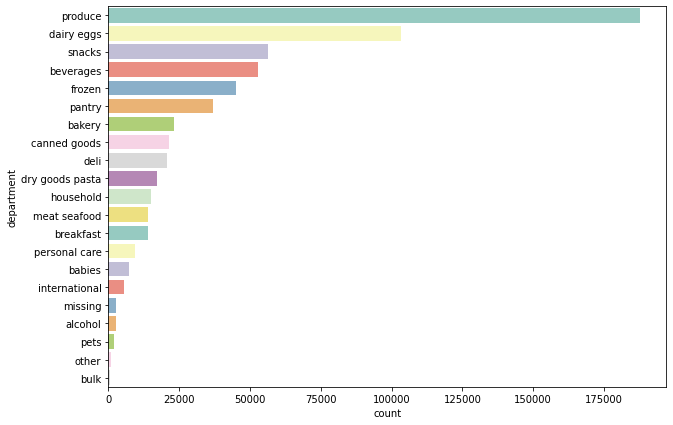

In [ ]:
#Most Popular Departments
plt.figure(figsize=(10,7))
sns.countplot(y='department', palette='Set3',data=order_details,
  order=order_details['department'].value_counts().index)
plt.show()

### **Most Popular Aisles**

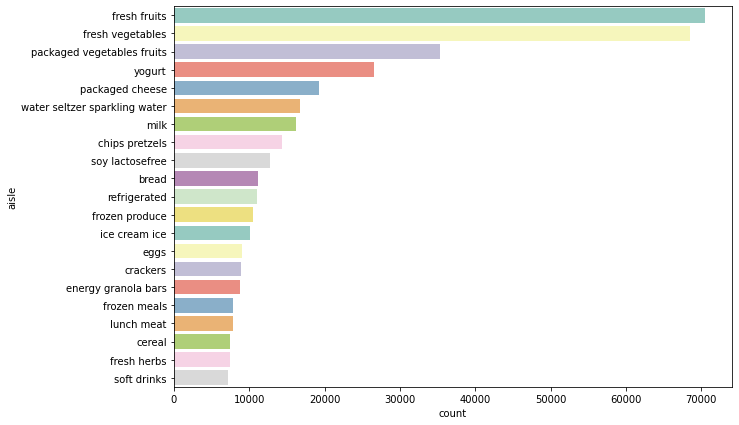

In [ ]:
#Top 20 in Aisle Popularity, there were too many unique aisles to include all
plt.figure(figsize=(10,7))
sns.countplot(y='aisle', palette='Set3',data=order_details,
  order=order_details['aisle'].value_counts().iloc[:21].index)
plt.show()

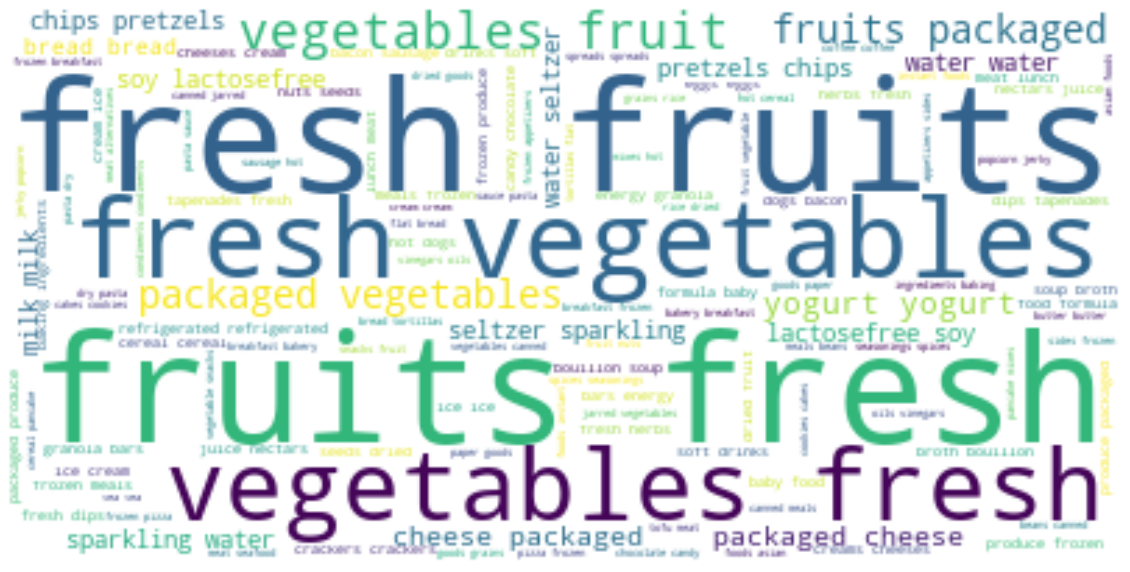

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(" ".join(order_details['aisle']))
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### **Most Popular Products**

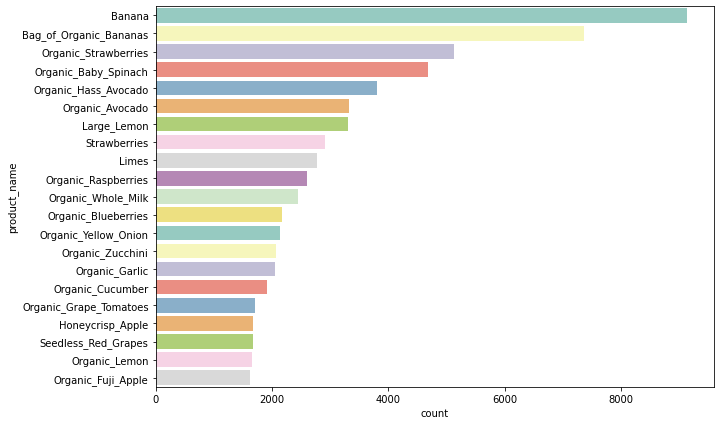

In [ ]:
#Top 20 in Product Popularity, there were too many unique products to include all
plt.figure(figsize=(10,7))
sns.countplot(y='product_name', palette='Set3',data=order_details,
  order=order_details['product_name'].value_counts().iloc[:21].index)
plt.show()

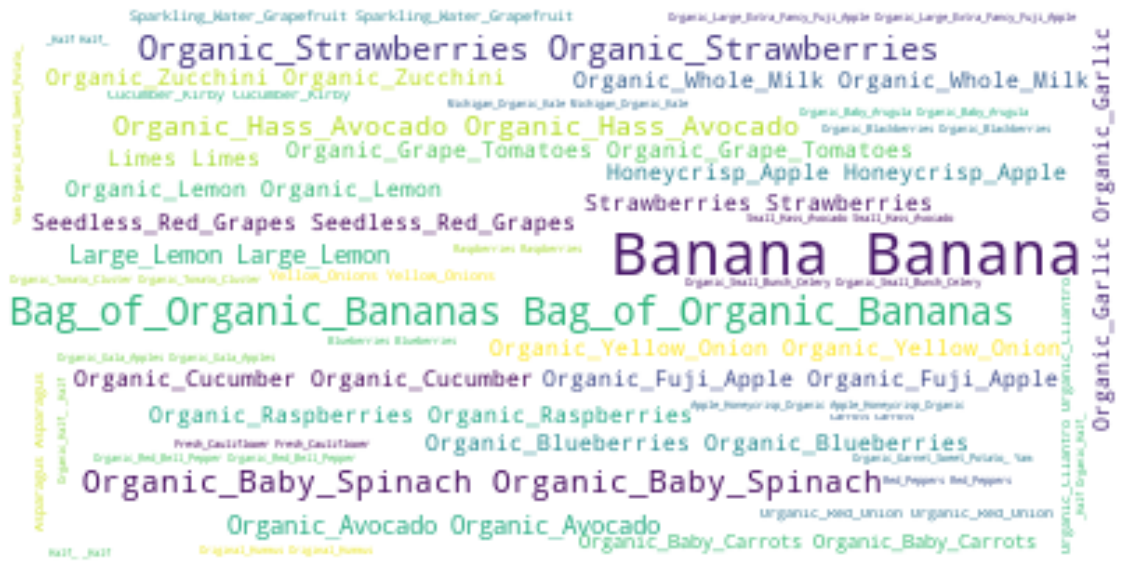

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(" ".join(order_details['product_name']))
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### **Top Shoppers**

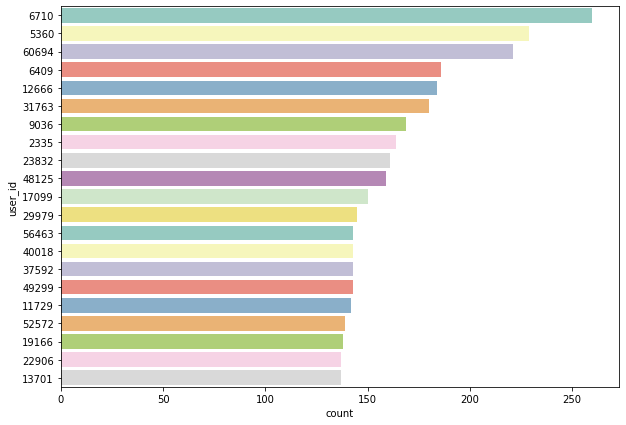

In [ ]:
#Top 20 Users
plt.figure(figsize=(10,7))
sns.countplot(y='user_id', palette='Set3',data=order_details,
  order=order_details['user_id'].value_counts().iloc[:21].index)
plt.show()

### **Most Popular Days**

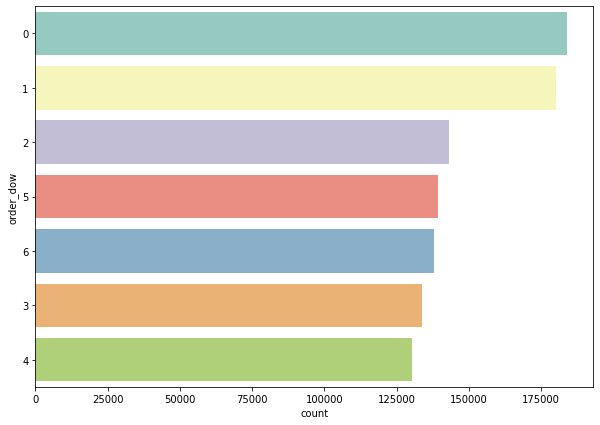

In [ ]:
#Most Popular Day to Order
#Days are Numbered were 0=Saturday through 6=Friday
plt.figure(figsize=(10,7))
sns.countplot(y='order_dow', palette='Set3',data=orders_df,
  order=orders_df['order_dow'].value_counts().index)
plt.show()

### **Most Popular Shopping Times**

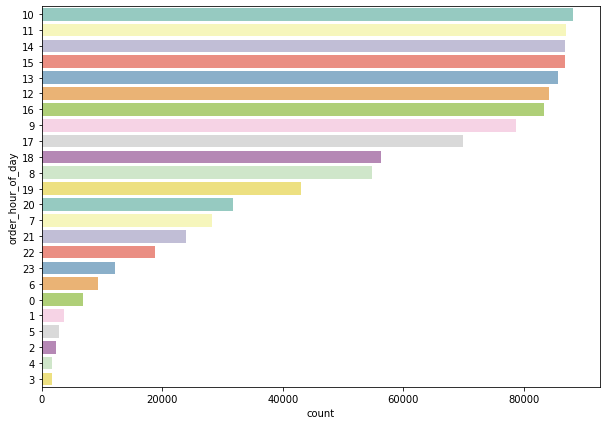

In [ ]:
#Most popular time to purchase
plt.figure(figsize=(10,7))
sns.countplot(y='order_hour_of_day', palette='Set3',data=orders_df,
  order=orders_df['order_hour_of_day'].value_counts().index)
plt.show()

### **How Many Orders Per User**

In [ ]:
#How many orders do users make?
order_details.groupby('user_id')['order_id'].nunique().describe()

count    41234.000000
mean         1.504317
std          0.887969
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         13.000000
Name: order_id, dtype: float64

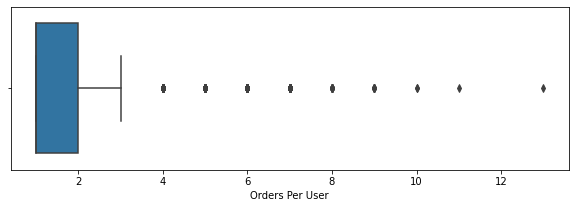

In [ ]:
#visualize
plt.figure (figsize=(10,3))
sns.boxplot(x=order_details.groupby('user_id')['order_id'].nunique())
plt.xlabel('Orders Per User')
plt.show()

### **How many items per customer per year?**

In [ ]:
#How many items do customers order over the year?
order_details.groupby('user_id')['qty_purchased'].sum().describe()

count    41234.000000
mean       131.961440
std        222.065457
min          1.000000
25%         21.000000
50%         55.000000
75%        153.000000
max       8183.000000
Name: qty_purchased, dtype: float64

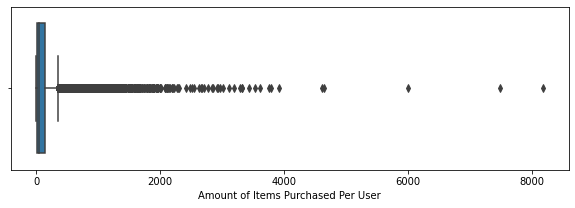

In [ ]:
#visualize
plt.figure (figsize=(10,3))
sns.boxplot(order_details.groupby('user_id')['qty_purchased'].sum())
plt.xlabel('Amount of Items Purchased Per User')
plt.show()

### **How many items per order?**

In [ ]:
#How many items per order?
order_details.groupby('order_id')['qty_purchased'].sum().describe()

count    62029.000000
mean        87.721840
std        143.892904
min          1.000000
25%         15.000000
50%         45.000000
75%        105.000000
max       8128.000000
Name: qty_purchased, dtype: float64

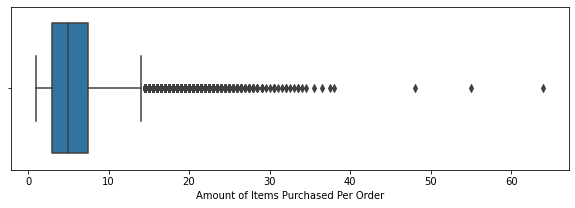

In [ ]:
#visualize
plt.figure (figsize=(10,3))
sns.boxplot(order_details.groupby('order_id')['qty_purchased'].mean())
plt.xlabel('Amount of Items Purchased Per Order')
plt.show()

### **Frequency of product purchase**

In [ ]:
#How many times was each product ordered?
order_details.groupby('product_id')['qty_purchased'].sum().describe()

count    31728.000000
mean       171.498298
std        829.234361
min          1.000000
25%         12.000000
50%         33.000000
75%        102.000000
max      44769.000000
Name: qty_purchased, dtype: float64

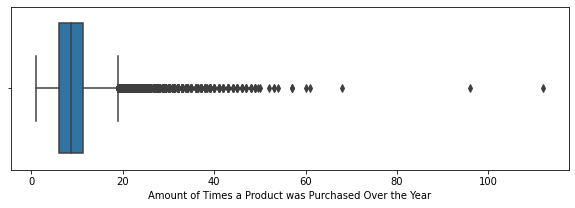

In [ ]:
#visualize
plt.figure (figsize=(10,3))
sns.boxplot(order_details.groupby('product_id')['qty_purchased'].mean())
plt.xlabel('Amount of Times a Product was Purchased Over the Year')
plt.show()

### **Time Between Orders**

In [ ]:
#How long since last order?
orders_df.groupby('order_id')['days_since_prior_order'].mean().describe()

count    985475.000000
mean         11.102506
std           9.186663
min           0.000000
25%           4.000000
50%           7.000000
75%          15.000000
max          30.000000
Name: days_since_prior_order, dtype: float64

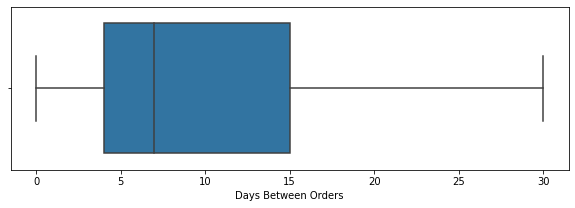

In [ ]:
plt.figure (figsize=(10,3))
sns.boxplot(orders_df.groupby('order_id')['days_since_prior_order'].mean())
plt.xlabel('Days Between Orders')
plt.show()

# **Weighted Score Calculation**

We will use a weighted rating formula as a metric or score for recommending most popular products.

Mathematically, it is represented as:

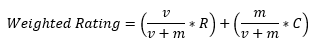

*   **v** is the amount of orders a product was purchased in
*   **m** is the minimum amount of orders a product was purchased in, in order to be able to make it into the list. Must be in 90th percentile. 
*   **R** is the average quantity a product was purchased in an order
*   **C** is the mean amount of orders a product was purchased in across the whole report.

In [ ]:
#Calculate mean amount of orders a product was purchased in across the data
C = product_details['num_orders'].mean()
print(C)

20.127080181543118


In [ ]:
#calculate m, the minimum amount of orders a product was purchased in, in order to 
#make it into the reccomendation system. 
m=product_details['num_orders'].quantile(0.90)
print(m)

35.0


In [ ]:
#create a df that contains products that were purchased >= 35 times
q_product_details = product_details.copy().loc[product_details['num_orders'] >= m]
q_product_details.shape

(3230, 9)

In [ ]:
product_details.shape

(31728, 9)

In [ ]:
#Calculate weighted pruchase for each qaulified product.
def weighted_purchase(x, m=m, C=C):
  v = x['num_orders']
  R = x['qty_purchased']/x['num_orders']
  #calculate Weighted Rating
  weighted_rating = ((v/(v+m)*R) + ((m/(m+v))*C))
  return weighted_rating

In [ ]:
#Define a new feature of q_product_hist & calculate it's value with weighted_rating
q_product_details['score'] = q_product_details.apply(weighted_purchase, axis=1)

In [ ]:
#sort based on calculated score
q_product_details = q_product_details.sort_values('score', ascending=False)

#view top 20
q_product_details.head(21)

,product_id,order_id,product_name,aisle_id,aisle,department_id,department,num_orders,qty_purchased,score
17592,27555,"{91521, 87809, 48642, 645766, 2260999, 1912202...",{Organic_Dried_Granny_Apple_Chips},{107},{chips pretzels},{19},{snacks},43,731,18.403177
14006,21914,"{1599873, 657154, 551046, 1206790, 89224, 2159...",{Peanut_Butter_&_Jelly_Fruit_&_Nut_Food_Bar},{3},{energy granola bars},{19},{snacks},35,494,17.120683
29909,46807,"{2138242, 96905, 71310, 69905, 100113, 568601,...","{Bananas,_Raspberries_&_Oats_Organic_Baby_Food}",{92},{baby food formula},{18},{babies},40,573,17.032637
25753,40342,"{2242051, 98569, 7947, 105229, 52878, 62351, 2...",{Tikka_Masala_Mild_Indian_Simmer_Sauce},{76},{indian foods},{6},{international},35,485,16.992112
9590,15097,"{18562, 95110, 40839, 1565576, 521097, 23820, ...",{Light_Mayonnaise},{72},{condiments},{13},{pantry},44,624,16.815795
8172,12955,"{2270080, 36355, 107780, 729358, 429968, 98962...","{Super_Foods/Organic_Apples,_Spinach,_Peas_&_B...",{92},{baby food formula},{18},{babies},36,489,16.809124
30030,46992,"{103808, 103937, 554373, 6280, 10123, 21012, 7...",{Real_Cheddar_Baked_Cheese_Puffs},{23},{popcorn jerky},{19},{snacks},36,480,16.682363
5834,9177,"{359942, 20104, 50443, 1077395, 91156, 103576,...","{Friends_Honey,_Chocolate_&_Chocolate_Chip_Bun...",{61},{cookies cakes},{19},{snacks},36,479,16.668279
4513,7079,"{15367, 18189, 1281806, 38926, 2530833, 70289,...",{Organic_Alfalfa_Sprouts},{83},{fresh vegetables},{4},{produce},35,458,16.606397
23626,37003,"{9216, 9985, 2031618, 25091, 58108, 38922, 554...","{Organic_Apples,_Carrots_and_Parsnips_Puree}",{92},{baby food formula},{18},{babies},40,538,16.565971


In [ ]:
q_product_details = pd.DataFrame(data = q_product_details)
q_product_details.to_csv('order_top_products_details.csv')

# **Prep for Personalized Recomednation Systems**

Here, we will consider users purchases' of different items, as well as purchases of similar users, to recommend the best products for future pruchases. 

Some factors to consider while creating this, and many recommendation models, is sparseness of data, the high amounts of items a user has not purchased, and users for which the system has no prior information to make recomendations.  for becuase they don't have prior purchases.

In this section, we will focus on creating systems that recomend products based on user similarity and product similarity.

Finally, we'll creat an Alternating Least Squares Model to make recommendations or products for users and users for products. 

## **Weighted Score Calculation**

In [ ]:
#calculate score for each product in product_details
product_details['score'] = product_details.apply(weighted_purchase, axis=1)
product_details

,product_id,order_id,product_name,aisle_id,aisle,department_id,department,num_orders,qty_purchased,score
0,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks},42,265,12.590231
1,2,"{12209, 1550225, 1455635, 2481009, 105042, 59102}",{All-Seasons_Salt},{104},{spices seasonings},{13},{pantry},6,82,19.181654
2,3,"{36875, 2339119}",{Robust_Golden_Unsweetened_Oolong_Tea},{94},{tea},{7},{beverages},2,6,19.201292
3,4,"{13379, 63749, 2472936, 90473, 2179434, 934893...",{Smart_Ones_Classic_Favorites_Mini_Rigatoni_Wi...,{38},{frozen meals},{1},{frozen},11,91,17.292344
4,8,"{66768, 507098, 1896509, 1095600}",{Cut_Russet_Potatoes_Steam_N'_Mash},{116},{frozen produce},{1},{frozen},4,73,19.934559
...,...,...,...,...,...,...,...,...,...,...
31723,49681,"{344568, 768013, 711477}",{Spaghetti_with_Meatballs_and_Sauce_Meal},{38},{frozen meals},{1},{frozen},3,33,19.406521
31724,49682,"{2165322, 679895}",{California_Limeade},{98},{juice nectars},{7},{beverages},2,15,19.444535
31725,49683,"{278529, 57351, 73744, 8211, 106516, 65568, 41...",{Cucumber_Kirby},{83},{fresh vegetables},{4},{produce},1485,11082,7.754242
31726,49686,{2133651},{Artisan_Baguette},{112},{bread},{3},{bakery},1,1,19.595772


In [ ]:
#investigate descriptive statistics of score column
product_details['score'].describe()

count    31728.000000
mean        18.112226
std          2.450399
min          4.397790
25%         17.464723
50%         19.143363
75%         19.679106
max         22.679106
Name: score, dtype: float64

In [ ]:
#export product_details to csv for use in Dashboard.
product_details.to_csv('product_details.csv')

## **Merge in Users**

In [ ]:
#merge in users
product_details = product_details.merge(user_product_hist[['product_id', 'user_id']],
                                  how='inner', on='product_id')
product_details

,product_id,order_id,product_name,aisle_id,aisle,department_id,department,num_orders,qty_purchased,score,user_id
0,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks},42,265,12.590231,751
1,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks},42,265,12.590231,1540
2,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks},42,265,12.590231,2221
3,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks},42,265,12.590231,4122
4,1,"{1641609, 33675, 1753356, 298510, 47122, 25866...",{Chocolate_Sandwich_Cookies},{61},{cookies cakes},{19},{snacks},42,265,12.590231,9694
...,...,...,...,...,...,...,...,...,...,...,...
583670,49683,"{278529, 57351, 73744, 8211, 106516, 65568, 41...",{Cucumber_Kirby},{83},{fresh vegetables},{4},{produce},1485,11082,7.754242,63073
583671,49683,"{278529, 57351, 73744, 8211, 106516, 65568, 41...",{Cucumber_Kirby},{83},{fresh vegetables},{4},{produce},1485,11082,7.754242,63087
583672,49686,{2133651},{Artisan_Baguette},{112},{bread},{3},{bakery},1,1,19.595772,45297
583673,49688,"{26098, 2198380}",{Fresh_Foaming_Cleanser},{73},{facial care},{11},{personal care},2,14,19.417508,39679


## **Split Data into Training and Test Sets**

In [ ]:
#split into training and test sets
product_train = product_details
product_train, product_test = train_test_split(product_train, test_size = 0.8, random_state= 24)

In [ ]:
product_train

,product_id,order_id,product_name,aisle_id,aisle,department_id,department,num_orders,qty_purchased,score,user_id
245336,21914,"{1599873, 657154, 551046, 1206790, 89224, 2159...",{Peanut_Butter_&_Jelly_Fruit_&_Nut_Food_Bar},{3},{energy granola bars},{19},{snacks},35,494,17.120683,41303
219131,20345,"{774145, 666628, 2589701, 108041, 56843, 16957...",{Thin_Crust_Pepperoni_Pizza},{79},{frozen pizza},{1},{frozen},235,1977,9.931288,52919
489358,42356,"{1051648, 103937, 89603, 5124, 78853, 2516998,...",{Strawberry_Preserves},{88},{spreads},{13},{pantry},292,2940,11.145100,29590
430365,37158,"{51714, 64002, 1611268, 40452, 78854, 1108486,...",{Chicken_&_Maple_Breakfast_Sausage},{52},{frozen breakfast},{1},{frozen},324,2533,9.017960,40249
137126,13166,"{68099, 103428, 106503, 1875463, 32267, 105485...","{Organic_Milk_Reduced_Fat,_2%_Milkfat}",{84},{milk},{16},{dairy eggs},225,1079,6.859415,55877
...,...,...,...,...,...,...,...,...,...,...,...
478609,41400,"{54784, 960005, 78345, 1601033, 75277, 41486, ...",{Crunchy_Oats_'n_Honey_Granola_Bars},{3},{energy granola bars},{19},{snacks},191,806,6.683397,41413
516439,44570,"{2084864, 36866, 1074693, 2278918, 77831, 1757...",{Kale_Greens},{83},{fresh vegetables},{4},{produce},265,2004,9.028159,38122
211136,19571,"{79362, 46210, 294153, 27657, 1549, 45723, 792...",{Organix_Grain_Free_Chicken_&_Vegetable_Dog_Food},{40},{dog food care},{8},{pets},22,222,16.253470,49802
899,79,"{1915520, 86660, 58372, 509574, 910603, 95373,...",{Wild_Albacore_Tuna_No_Salt_Added},{95},{canned meat seafood},{15},{canned goods},76,726,12.886917,54471


In [ ]:
product_test

,product_id,order_id,product_name,aisle_id,aisle,department_id,department,num_orders,qty_purchased,score,user_id
5113,432,"{90115, 1136643, 587781, 88073, 86026, 1103882...",{Vanilla_Almond_Breeze_Almond_Milk},{91},{soy lactosefree},{16},{dairy eggs},645,3838,6.680070,11956
474887,41055,"{630657, 1827459, 1697670, 73607, 2151303, 449...",{Organic_Red_Wine_Vineger},{19},{oils vinegars},{13},{pantry},48,529,14.860817,38355
134582,12872,"{103937, 1313283, 1483275, 1565196, 72721, 162...",{Penne_Rigate},{131},{dry pasta},{9},{dry goods pasta},183,1830,11.625907,61386
308955,26683,"{1300355, 565507, 387461, 1376263, 44424, 2394...",{Cafe_Latte_Pure_Lightly_Sweetened_Iced_Coffee...,{91},{soy lactosefree},{16},{dairy eggs},62,521,12.633483,3737
390334,33509,"{56482, 61155, 78820, 2534020, 71431, 67738, 5...",{Italian_Herbs_&_Olive_Oil_Mozzarella_Stix},{129},{frozen appetizers sides},{1},{frozen},17,178,16.970150,12772
...,...,...,...,...,...,...,...,...,...,...,...
23795,2592,"{1396984, 924612, 2516038, 230921, 28042, 2140...",{Maple_Almond_Bar},{100},{missing},{21},{missing},16,142,16.597016,63013
242518,21903,"{32769, 278529, 90114, 73730, 196613, 1875974,...",{Organic_Baby_Spinach},{123},{packaged vegetables fruits},{4},{produce},4680,34215,7.406033,20932
201545,18656,"{1983491, 37894, 2156559, 95249, 59413, 7703, ...",{Organic_Red_Potato},{83},{fresh vegetables},{4},{produce},214,2157,11.491758,42203
236979,21553,"{45574, 25610, 601106, 1020449, 4139, 43, 7735...",{Lowfat_2%_Milkfat_Cottage_Cheese},{108},{other creams cheeses},{16},{dairy eggs},88,741,11.751608,53727


## **Distribution of Weighted Score in Training Set**

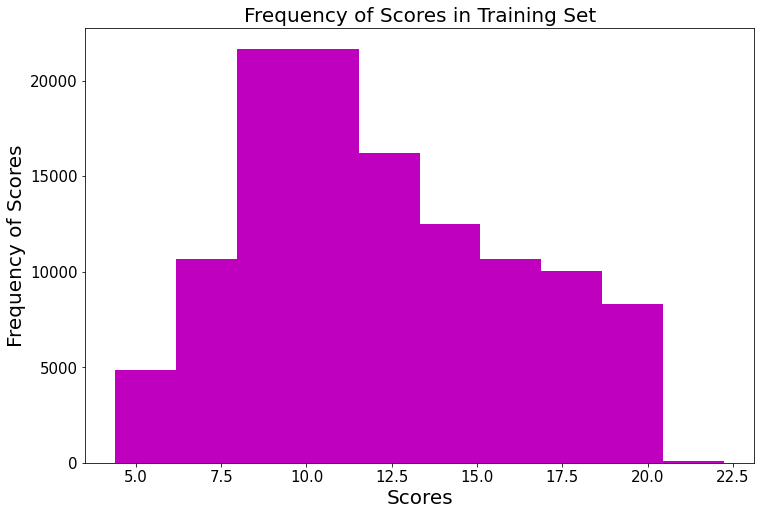

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(product_train['score'], color='m')
plt.tick_params(labelsize = 15)
plt.title('Frequency of Scores in Training Set', fontsize = 20)
plt.xlabel('Scores', fontsize = 20)
plt.ylabel('Frequency of Scores', fontsize = 20)
plt.show()

# **Similar Product Recomendation System**

### **User-Item Sparse Matrix**

In [ ]:
#create user-item sparse matrix function
def get_user_item_sparse_matrix(df):
  sparse_data = sparse.csr_matrix((df.score, (df.user_id, df.product_id)))
  return sparse_data

In [ ]:
#Apply user item sparse matrix function to training data
product_train_sparse_data = get_user_item_sparse_matrix(product_train)

In [ ]:
#Apply user item sparse matrix function to testing data
product_test_sparse_data = get_user_item_sparse_matrix(product_test)

In [ ]:
#global average score
global_average_score = product_train_sparse_data.sum()/product_train_sparse_data.count_nonzero()
print('Global Average Score: ', global_average_score)

Global Average Score:  12.156165542797181


In [ ]:
#Function to calculate average score from sparse matrix
def get_average_score(sparse_matrix, is_user):
  ax = 1 if is_user else 0
  sum_of_scores = sparse_matrix.sum(axis= ax).A1
  num_of_scores = (sparse_matrix !=0).sum(axis = ax).A1
  rows, cols = sparse_matrix.shape
  average_score = {i: sum_of_scores[i]/num_of_scores[i] for i in range(rows if is_user else cols) if num_of_scores[i]!=0}
  return average_score

In [ ]:
#average user score
avg_user_score = get_average_score(product_train_sparse_data, True)

In [ ]:
#Get average user score of user 50, just to see what happens
avg_user_score[50]

7.490729047524255

In [ ]:
#average product score
avg_product_score = get_average_score(product_train_sparse_data, False)

In [ ]:
#Get average product score of item 14814, just to see what happens
avg_product_score[14814]

13.170594792579033

In [ ]:
#Check cold start problem for user
total_users = len(np.unique(product_details['user_id']))
train_users = len(avg_user_score)
remaining_users = total_users - train_users
percent_remaining_users = (remaining_users/total_users)*100
print('Total Number of Users: ', total_users)
print('Training Set Users: ', train_users)
print('Number of Users Outside Training Set: {} ({}%)'.format(remaining_users, percent_remaining_users))

Total Number of Users:  41234
Training Set Users:  33935
Number of Users Outside Training Set: 7299 (17.70141145656497%)


In [ ]:
#Check cold start problem for product
total_products = len(np.unique(product_hist['product_id']))
train_products = len(avg_product_score)
remaining_products = total_products - train_products
percent_remaining_products = (remaining_products/total_products)*100
print('Total Number of Products: ', total_products)
print('Training Set Products: ', train_products)
print('Number of Products Outside Training Set: {} ({}%)'.format(remaining_products, percent_remaining_products))

Total Number of Products:  31728
Training Set Products:  17981
Number of Products Outside Training Set: 13747 (43.327660110943015%)


Both users and products bring up the cold start problem. Meaning, they both will have some observations with no proper score available. 

### **Similarity Computation for Top 100 Users**

In [ ]:
#Function to find Target User Similarity Matrix to top 100 users
def compute_user_similarity(sparse_matrix, limit = 100):
  row_index, col_index = sparse_matrix.nonzero()
  rows = np.unique(row_index)
  similar_arr = np.zeros(61700).reshape(617,100)

  for row in rows[:limit]:
    sim = cosine_similarity(sparse_matrix.getrow(row), product_train_sparse_data).ravel()
    similar_indices = sim.argsort()[-limit:]
    similar = sim[similar_indices]
    similar_arr[row] = similar

  return similar_arr 

In [ ]:
#Run function and view for user 10
similar_user_matrix= compute_user_similarity(product_train_sparse_data, 100)
similar_user_matrix[10]

array([0.16840792, 0.16863757, 0.17181838, 0.17248605, 0.17329818,
       0.17358459, 0.17490782, 0.17794998, 0.17794998, 0.17819144,
       0.17822826, 0.17887663, 0.18224597, 0.1844204 , 0.1844204 ,
       0.1844204 , 0.18560575, 0.18725934, 0.18725934, 0.18725934,
       0.18725934, 0.18725934, 0.18725934, 0.18725934, 0.18725934,
       0.18725934, 0.18725934, 0.18725934, 0.18725934, 0.1885066 ,
       0.19024575, 0.19127105, 0.19132037, 0.19380673, 0.19380673,
       0.19380673, 0.19380673, 0.19380673, 0.19380673, 0.19380673,
       0.19448391, 0.19612766, 0.19612766, 0.19612766, 0.19612766,
       0.19612766, 0.19684744, 0.19722987, 0.19740852, 0.19896065,
       0.19896065, 0.19896065, 0.19896065, 0.19896065, 0.19896065,
       0.19896065, 0.19896065, 0.19896065, 0.19896065, 0.19896065,
       0.19896065, 0.19896065, 0.20231063, 0.21198033, 0.21198033,
       0.21198033, 0.21198033, 0.21394817, 0.21394817, 0.21394817,
       0.21714495, 0.21714495, 0.21714495, 0.21714495, 0.21714

In [ ]:
sim_user_output = pd.DataFrame(data=similar_user_matrix[10])

In [ ]:
#export similiar user output to a csv
sim_user_output.to_csv('order_sim_user_output.csv')

## **Product Similarity Matrix**

In [ ]:
#Function for Product Similarity Matrix
def compute_prodcut_similarity_count(sparse_matrix, product_details, product_id):
  similarity = cosine_similarity(sparse_matrix.T, dense_output=False)
  num_similar_products = product_hist.loc[product_id][1],similarity[product_id].count_nonzero()
  return num_similar_products

In [ ]:
#Find a similar product for product 21914	
similar_products = compute_prodcut_similarity_count(product_train_sparse_data, product_details, 21914)
print('Similar Products = ', similar_products)

Similar Products =  ('Berry_Supreme_Pie', 68)


In [ ]:
#Find a similar product for product 6550, organic brown eggs
similar_products = compute_prodcut_similarity_count(product_train_sparse_data, product_details, 6550)
print('Similar Products = ', similar_products)

Similar Products =  ('Teriyaki_Chicken_Bowl', 59)


## **Sample Sparse Matrix**

We will create a function to generate a Sample Sparse Matrix. This will allow us to generate new similarity features from the sample sparse matrix. 

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, num_users, num_products):
  users, products, score = sparse.find(sparse_matrix)
  unique_users = np.unique(users)
  unique_products = np.unique(products)
  np.random.seed(15)
  user = np.random.choice(unique_users, num_users, replace = False)
  product = np.random.choice(unique_products, num_products, replace=True)
  mask = np.logical_and(np.isin(users, user), np.isin(products, product))
  sparse_matrix = sparse.csr_matrix((score[mask],(users[mask], products[mask])),
                                    shape = (max(user)+1, max(product)+1))
  return sparse_matrix

In [ ]:
#Sample Sparse Matrix for Training Data
train_sample_sparse_matrix = get_sample_sparse_matrix(product_train_sparse_data, 400, 100)

In [ ]:
train_sample_sparse_matrix

<62889x49080 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [ ]:
#Sample Sparse Matrix for Test Data
test_sample_sparse_matrix = get_sample_sparse_matrix(product_test_sparse_data, 400, 100)

In [ ]:
test_sample_sparse_matrix

<63061x49589 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

## **Generate Similar Features**

The following function will recommend a similar product to a user and report scores for that product of 5 similar users and 5 similar products. 

In [ ]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_score = get_average_score(sample_sparse_matrix, False)
    global_avg_users = get_average_score(sample_sparse_matrix, True)
    global_avg_products = get_average_score(sample_sparse_matrix, False)
    sample_train_users, sample_train_products, sample_train_scores = sparse.find(sample_sparse_matrix)
    new_features_csv = open('new_features.csv', mode='w')

    for user, product, score in zip(sample_train_users, sample_train_products, sample_train_scores):
      similar_arr = list()
      similar_arr.append(user)
      similar_arr.append(product)
      similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())

      similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
      indices = np.argsort(-similar_users)[1:]
      scores = sample_sparse_matrix[indices, product].toarray().ravel()
      top_similar_user_scores = list(scores[scores !=0][:5])
      top_similar_user_scores.extend([global_avg_score[product]]*(5-len(scores)))
      similar_arr.extend(top_similar_user_scores)

      similar_products = cosine_similarity(sample_sparse_matrix[:,product].T, sample_sparse_matrix.T).ravel()
      similar_products_indices = np.argsort(-similar_products)[1:]
      similar_products_scores = sample_sparse_matrix[user,similar_products_indices].toarray().ravel()
      top_similar_products_scores = list(similar_products_scores[similar_products_scores !=0][:5])
      top_similar_products_scores.extend([global_avg_users[user]]*(5-len(top_similar_products_scores)))
      similar_arr.extend(top_similar_products_scores)

      similar_arr.append(global_avg_users[user])
      similar_arr.append(global_avg_products[product])
      similar_arr.append(score)

      new_features_csv.write(','.join(map(str,similar_arr)))
      new_features_csv.write('\n')

    new_features_csv.close()     
    
    new_features_df = pd.read_csv('new_features.csv', names = ['user_id', 
          'product_id', 'global_avg', 'similar_user_score1', 'similar_user_score2', 
          'similar_user_score3', 'similar_user_score4', 'similar_user_score5', 
          'similar_product1', 'similar_product2', 'similar_product3', 
          'similar_product4', 'similar_product5', 'user_avg', 'product_avg', 'score'])
  
    return new_features_df


In [ ]:
#Generate Similar Features for the Training Data
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [ ]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features

,user_id,product_id,global_avg,similar_user_score1,similar_user_score2,similar_user_score3,similar_user_score4,similar_user_score5,similar_product1,similar_product2,similar_product3,similar_product4,similar_product5,user_avg,product_avg,score
0,47347,15653,13.584363,18.305632,18.305632,18.305632,18.305632,18.305632,18.305632,18.305632,18.305632,0.00000,0.0,0.0,0.0,0.0
1,1459,23026,13.584363,15.624130,15.624130,15.624130,15.624130,15.624130,15.624130,15.624130,15.624130,0.00000,0.0,0.0,0.0,0.0
2,36516,24214,13.584363,18.123814,18.123814,18.123814,18.123814,18.123814,18.123814,18.123814,18.123814,0.00000,0.0,0.0,0.0,0.0
3,10161,28476,13.584363,9.782480,9.782480,9.782480,9.782480,9.782480,9.782480,9.782480,9.782480,9.78248,0.0,0.0,0.0,0.0
4,23768,28476,13.584363,9.782480,9.782480,9.782480,9.782480,9.782480,9.782480,9.782480,9.782480,9.78248,0.0,0.0,0.0,0.0
5,45821,30183,13.584363,11.995752,11.995752,11.995752,11.995752,11.995752,11.995752,11.995752,11.995752,0.00000,0.0,0.0,0.0,0.0
6,40061,32177,13.584363,11.476255,11.476255,11.476255,11.476255,11.476255,11.476255,11.476255,11.476255,0.00000,0.0,0.0,0.0,0.0


In [ ]:
#Generate Similar Features for Test Data
test_new_similar_features = create_new_similar_features(test_sample_sparse_matrix)

In [ ]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,product_id,global_avg,similar_user_score1,similar_user_score2,similar_user_score3,similar_user_score4,similar_user_score5,similar_product1,similar_product2,similar_product3,similar_product4,similar_product5,user_avg,product_avg,score
0,22906,3390,13.911259,14.593098,14.593098,14.593098,14.593098,14.593098,14.593098,14.593098,14.593098,0.000000,0.0,0.0,0.0,0.0
1,43334,11123,13.911259,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,0.0,0.0,0.0,0.0
2,62706,11123,13.911259,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,0.0,0.0,0.0,0.0
3,35487,15146,13.911259,17.911195,17.911195,17.911195,17.911195,17.911195,17.911195,17.911195,17.911195,0.000000,0.0,0.0,0.0,0.0
4,43293,20867,13.911259,19.679106,19.679106,19.679106,19.679106,19.679106,19.679106,19.679106,19.679106,0.000000,0.0,0.0,0.0,0.0


In [ ]:
test_new_similar_features

,user_id,product_id,global_avg,similar_user_score1,similar_user_score2,similar_user_score3,similar_user_score4,similar_user_score5,similar_product1,similar_product2,similar_product3,similar_product4,similar_product5,user_avg,product_avg,score
0,22906,3390,13.911259,14.593098,14.593098,14.593098,14.593098,14.593098,14.593098,14.593098,14.593098,0.000000,0.000000,0.000000,0.0,0.0
1,43334,11123,13.911259,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,0.000000,0.000000,0.0,0.0
2,62706,11123,13.911259,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,10.040655,0.000000,0.000000,0.0,0.0
3,35487,15146,13.911259,17.911195,17.911195,17.911195,17.911195,17.911195,17.911195,17.911195,17.911195,0.000000,0.000000,0.000000,0.0,0.0
4,43293,20867,13.911259,19.679106,19.679106,19.679106,19.679106,19.679106,19.679106,19.679106,19.679106,0.000000,0.000000,0.000000,0.0,0.0
5,35517,25032,13.911259,17.623814,17.623814,17.623814,17.623814,17.623814,17.623814,17.623814,17.623814,0.000000,0.000000,0.000000,0.0,0.0
6,21883,31805,13.911259,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,0.0,0.0
7,29971,31805,13.911259,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,0.0,0.0
8,39786,31805,13.911259,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,0.0,0.0
9,40361,31805,13.911259,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,9.315934,0.0,0.0


In [ ]:
#export user_recs to a csv
test_new_similar_features.to_csv('order_test_new_similar_features.csv')

# **ALS Model Recommendation System**

This will take our large matrix and factor into a smaller representaion of our original matrix through alternating least squares. ALS creates two, or more, lower dimensional matrices, that when multiplied together, the product is equivalent to the larger, original matrix. 

To find the best hyperparameters, a tuning exercise was used but is very timley to run. The tuning exercise started by testing single models and finished with an inbuilt method that tested many values for hyperparameters and returned the best one, based on RMSE. In an effort to run through code faster, the tuning exercise has been commented out but a screenshot of the output is shown. 

## **Prep for ALS Model**

In [ ]:
#initialize spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

In [ ]:
#Convert order_details to spark df
spark_df = spark.createDataFrame(product_details[['user_id', 'product_id', 'score']])

In [ ]:
#check data type of product_id, as ALS only accepts integers for product id's
dict(spark_df.dtypes)['product_id']

'bigint'

In [ ]:
#check data type of user_id, as ALS only accepts integers for user_id's
dict(spark_df.dtypes)['user_id']

'bigint'

In [ ]:
#Split data into train & test set
(train, test) = spark_df.randomSplit([0.8, 0.2], seed=124)

## **Tune Hyperparameters**

In [ ]:
#default hyperparameters
als=ALS(maxIter=10,regParam=1, rank=10, userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

RMSE: 1.1249060774207642


In [ ]:
#change maxIter
als=ALS(maxIter=15,regParam=1, rank=10, userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

RMSE: 1.1027761153576243


In [ ]:
#change regParam
als=ALS(maxIter=15,regParam=0.5, rank=10, userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

RMSE: 0.6179044778394114


In [ ]:
#change regParam
als=ALS(maxIter=15,regParam=0.1, rank=10, userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

RMSE: 0.44852619414101585


In [ ]:
#change regParam
als=ALS(maxIter=15,regParam=0.05, rank=10, userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

RMSE: 1.0014975334545517


In [ ]:
#change rank
als=ALS(maxIter=15,regParam=0.1, rank=15, userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

RMSE: 0.45700819700604717


In [ ]:
#change regParam
als=ALS(maxIter=15,regParam=0.1, rank=20, userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

RMSE: 0.4528374858848669


## **Build ALS Model**

In [ ]:
#create model to test for best hyperparameters
als = ALS(userCol='user_id', itemCol='product_id', ratingCol='score',
          coldStartStrategy='drop', nonnegative=True)
#tune model using ParamGridBuilder
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [21,22, 23]) \
            .addGrid(als.maxIter, [14, 15, 16]) \
            .addGrid(als.regParam, [0.09,0.1, 0.11]) \
            .build()
#define evaluator as RMSE
evaluator = RegressionEvaluator(metricName='rmse', labelCol='score', 
                                predictionCol='prediction')

#Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, 
                    evaluator=evaluator, numFolds=5)

#fit ALS model from tuning
model = cv.fit(train)

#extract best model from tuning
best_model = model.bestModel

#generate predictions and evaluate using RMSE
predictions = best_model.transform(test)
rmse=evaluator.evaluate(predictions)

#print eval metrics & parameters
print('RMSE: '+str(rmse))
print('***Best Model***')
print('   Rank: '+str(best_model.rank))
print('   MaxIter: '+str(best_model._java_obj.parent().getMaxIter()))
print('   RegParam: '+str(best_model._java_obj.parent().getRegParam()))

RMSE: 0.3628773895713661
***Best Model***
   Rank: 22
   MaxIter: 16
   RegParam: 0.11


Best Model Output of Tuning Parameter Shown Above (to save time when running):

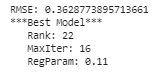

In [ ]:
# #ALS Model RMSE Elbow Plot to investigate how RMSE changes as iterations
# #increase. This will help determine if the best model is overfit or not. 
# num_iters=list(range(10,30))
# def plot_rmse_curve(training_data, testing_data, num_iters, reg_param, model_rank):
#   errors = []
#   for i in num_iters:
#     #train ALS model
#     model = ALS(maxIter=i, regParam=reg_param, rank=model_rank, userCol='user_id',
#                 itemCol='product_id',ratingCol='score',
#                 coldStartStrategy="drop",nonnegative=True )

#     #fit model
#     model = model.fit(training_data)

#     #generate predictions and evaluate rmse
#     evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
#                               predictionCol='prediction')

#     #generate predictions and evaluate using RMSE
#     predictions = model.transform(test)
#     rmse = evaluator.evaluate(predictions)
#     #add rmse to errors
#     errors.append(rmse)

#   #plot
#   plt.figure(figsize=(12,6))
#   plt.plot(num_iters, errors)
#   plt.xlabel('Number of Iterations')
#   plt.ylabel('RMSE')
#   plt.title('ALS Model Learning Curve')
#   plt.grid(True)
#   plt.show()

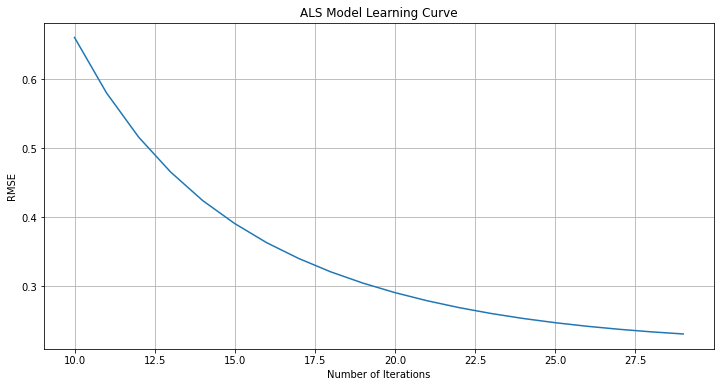

In [ ]:
# #plot learning curve 
# plot_rmse_curve(train, test, num_iters, 0.11, 22)

Output of Function called on arguments listed above (to save run time):

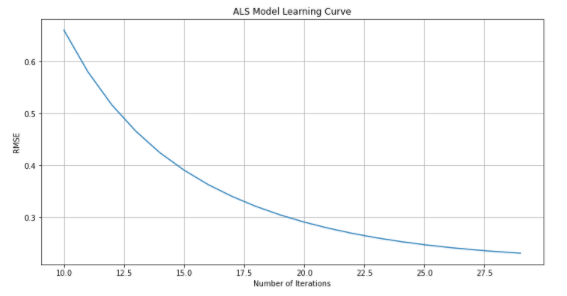

After 16 iterations, the curve converges at an RMSE of around 0.3

In [ ]:
#best model from tuning exercise, to save time.
als=ALS(maxIter=16,regParam=0.11, rank=22 ,userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

In [ ]:
#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

predictions.show()

RMSE: 0.3628773895713661
+-------+----------+------------------+----------+
|user_id|product_id|             score|prediction|
+-------+----------+------------------+----------+
|   6655|       148|13.800464139359313| 13.675666|
|  31004|       148|13.800464139359313| 13.703648|
|  15194|       148|13.800464139359313| 13.690504|
|  31331|       148|13.800464139359313| 13.708406|
|  16624|       148|13.800464139359313| 13.682918|
|   8069|       148|13.800464139359313| 13.657739|
|  13432|       148|13.800464139359313| 13.709842|
|    982|       148|13.800464139359313| 13.682146|
|  50277|       148|13.800464139359313|13.7176285|
|    814|       148|13.800464139359313| 13.644167|
|  55067|       148|13.800464139359313| 13.620244|
|  29085|       148|13.800464139359313|  13.61198|
|  38333|       148|13.800464139359313| 13.656194|
|  21664|       148|13.800464139359313| 13.706148|
|  33967|       148|13.800464139359313| 13.662582|
|  35250|      1238|18.906521219842343| 18.764782|
|  373

## **Recommend items to users**

In [ ]:
#provide user recommendations
user_recs = model.recommendForAllUsers(10) 

In [ ]:
#view 10 rows of user_recs
user_recs.show(10)

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    471|[[35944, 27.48752...|
|    496|[[35944, 27.32741...|
|    833|[[35944, 27.32677...|
|   1088|[[35944, 27.41280...|
|   1342|[[35944, 27.35387...|
|   1580|[[35944, 27.27544...|
|   1645|[[35944, 27.529],...|
|   1829|[[35944, 27.23606...|
|   1959|[[35944, 27.51665...|
|   2122|[[35944, 26.65728...|
+-------+--------------------+
only showing top 10 rows



In [ ]:
#export user_recs to a csv
user_recs.toPandas().to_csv('order_als_user_recs.csv')

## **Reccomend users to items**

In [ ]:
#provide item recommendations
item_recs = model.recommendForAllItems(10)

In [ ]:
#view 10 rows of item_recs
item_recs.show(10)

+----------+--------------------+
|product_id|     recommendations|
+----------+--------------------+
|       148|[[42582, 13.89430...|
|       471|[[8027, 19.440142...|
|       496|[[10889, 19.77166...|
|      1088|[[5469, 19.73911]...|
|      1238|[[42582, 19.08973...|
|      2142|[[42582, 19.79966...|
|      2366|[[59927, 20.06369...|
|      2659|[[51235, 19.19723...|
|      2866|[[838, 19.468239]...|
|      3175|[[5469, 19.659643...|
+----------+--------------------+
only showing top 10 rows



In [ ]:
#export item_recs to a csv
item_recs.toPandas().to_csv('order_als_item_recs.csv')

# **Conclusions**

Two attributes were used to evaluate the performance of the models, Root Mean Squared Error of the ALS model and the Distribution of the Weighted Score. 

Here RMSE refers to the error between the original matrix (user item interaction matrix) and the product of the two smaller matrices that we are trying to learn through ALS. 

Ultimately, the RMSE of the order based ALS model was lower than the quantity based ALS model and the distribution of the weighted scores was less skewed for the order based model than the quantity based model. Therefore the Order Based model is the better performing model. 


How the Recommender System Works:
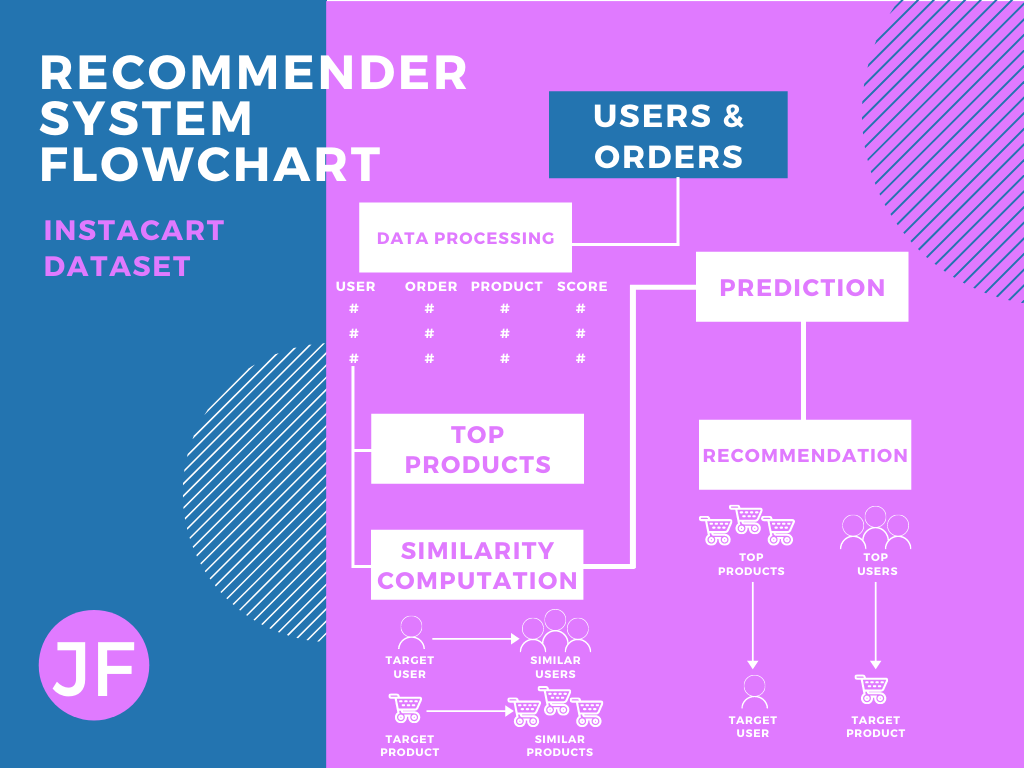


Instacart, or companies utizlizing this system, would simply need to continue inputting user & order information in, to get out recomendations. New users could automatically be recommended the top products. 